In [12]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib # For saving and loading models
import os # For file path operations

In [13]:
# Define user IDs and a directory to store models
USER_IDS = ['user_alpha', 'user_beta', 'user_gamma']
MODEL_DIR = 'trained_user_models'
os.makedirs(MODEL_DIR, exist_ok=True) # Create directory if it doesn't exist

In [14]:
def simulate_mouse_session(num_points=100, user_id="default", session_duration_secs=2.0):
    """
    Simulates a single mouse movement session with variations based on user_id.
    Returns a NumPy array of shape (num_points, 3): [(x, y, t), ...]
    Timestamps 't' are in seconds.
    """
    coords = []
    current_x, current_y = 50.0, 50.0 # Start at a somewhat central position
    time_step = session_duration_secs / num_points

    # Define user-specific behavior modifiers (simplified)
    if user_id == 'user_alpha': # More precise, slightly slower
        step_mean_x, step_std_x = 0.1, 0.8
        step_mean_y, step_std_y = 0.1, 0.8
        session_duration_secs = np.random.uniform(1.5, 3.5)
    elif user_id == 'user_beta': # Faster, slightly more erratic
        step_mean_x, step_std_x = 0.3, 1.5
        step_mean_y, step_std_y = 0.3, 1.5
        session_duration_secs = np.random.uniform(0.8, 2.5)
    elif user_id == 'user_gamma': # Average, but with more pauses (not explicitly modeled here, but features might capture)
        step_mean_x, step_std_x = 0.2, 1.2
        step_mean_y, step_std_y = 0.2, 1.2
        session_duration_secs = np.random.uniform(1.0, 3.0)
    else: # Default/Impostor behavior (more random)
        step_mean_x, step_std_x = 0, 2.5
        step_mean_y, step_std_y = 0, 2.5
        session_duration_secs = np.random.uniform(0.5, 4.0)


    for i in range(num_points):
        step_x = np.random.normal(step_mean_x, step_std_x)
        step_y = np.random.normal(step_mean_y, step_std_y)

        current_x += step_x
        current_y += step_y
        current_t = i * time_step
        coords.append((current_x, current_y, current_t))
    return np.array(coords)

In [15]:
def extract_features(session_data):
    """
    Extracts features from a single mouse movement session.
    session_data is a NumPy array of shape (num_points, 3) where columns are x, y, t.
    """
    if session_data.shape[0] < 3:
        return np.full(10, 0.0)

    x = session_data[:, 0]
    y = session_data[:, 1]
    t = session_data[:, 2]

    dt = np.diff(t)
    dt[dt <= 0] = 1e-6

    dx = np.diff(x)
    dy = np.diff(y)

    segment_distances = np.sqrt(dx**2 + dy**2)
    total_distance_moved = np.sum(segment_distances)
    path_duration = t[-1] - t[0] if len(t) > 0 else 0
    num_points = len(x)

    if len(dt) == 0:
        vx, vy, velocities_magnitude = np.array([]), np.array([]), np.array([])
    else:
        vx = dx / dt
        vy = dy / dt
        velocities_magnitude = np.sqrt(vx**2 + vy**2)

    avg_velocity_magnitude = np.mean(velocities_magnitude) if len(velocities_magnitude) > 0 else 0
    max_velocity = np.max(velocities_magnitude) if len(velocities_magnitude) > 0 else 0
    std_dev_velocity = np.std(velocities_magnitude) if len(velocities_magnitude) > 0 else 0

    if len(vx) < 2:
        ax, ay, accelerations_magnitude = np.array([]), np.array([]), np.array([])
    else:
        dt_accel = dt[:len(np.diff(vx))]
        if len(dt_accel) > 0 and len(np.diff(vx)) == len(dt_accel):
            ax = np.diff(vx) / dt_accel
            ay = np.diff(vy) / dt_accel
            accelerations_magnitude = np.sqrt(ax**2 + ay**2)
        else:
            ax, ay, accelerations_magnitude = np.array([]), np.array([]), np.array([])

    avg_acceleration_magnitude = np.mean(accelerations_magnitude) if len(accelerations_magnitude) > 0 else 0
    max_acceleration = np.max(accelerations_magnitude) if len(accelerations_magnitude) > 0 else 0
    std_dev_acceleration = np.std(accelerations_magnitude) if len(accelerations_magnitude) > 0 else 0

    if total_distance_moved > 1e-6:
        start_point = session_data[0, :2]
        end_point = session_data[-1, :2]
        euclidean_distance = np.sqrt(np.sum((end_point - start_point)**2))
        straightness = euclidean_distance / total_distance_moved
    else:
        straightness = 1.0 if num_points <= 1 else 0.0

    features = np.array([
        total_distance_moved, path_duration, num_points,
        avg_velocity_magnitude, max_velocity, std_dev_velocity,
        avg_acceleration_magnitude, max_acceleration, std_dev_acceleration,
        straightness
    ])
    return np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

In [16]:
trained_models = {}
num_training_sessions_per_user = 200 # Number of sessions to train each user's model

for user_id in USER_IDS:
    model_path = os.path.join(MODEL_DIR, f'model_{user_id}.joblib')
    print(f"\nProcessing user: {user_id}")

    if os.path.exists(model_path):
        print(f"Loading existing model for {user_id} from {model_path}")
        trained_models[user_id] = joblib.load(model_path)
    else:
        print(f"No existing model found. Training new model for {user_id}...")
        authentic_features_list = []
        for i in range(num_training_sessions_per_user):
            if (i+1) % 40 == 0:
                print(f"  Generated training session {i+1}/{num_training_sessions_per_user} for {user_id}")
            session = simulate_mouse_session(
                num_points=np.random.randint(50, 150),
                user_id=user_id, # Generate data specific to this user
                session_duration_secs=np.random.uniform(1.0, 3.0)
            )
            features = extract_features(session)
            authentic_features_list.append(features)
        
        X_authentic_user = np.array(authentic_features_list)

        if X_authentic_user.shape[0] > 0:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svm', OneClassSVM(nu=0.05, kernel="rbf", gamma='scale'))
            ])
            pipeline.fit(X_authentic_user)
            trained_models[user_id] = pipeline
            print(f"Training complete for {user_id}. Saving model to {model_path}")
            joblib.dump(pipeline, model_path)
        else:
            print(f"Warning: No training data generated for {user_id}. Model not trained.")

print(f"\nLoaded/Trained models for users: {list(trained_models.keys())}")


Processing user: user_alpha
No existing model found. Training new model for user_alpha...
  Generated training session 40/200 for user_alpha
  Generated training session 80/200 for user_alpha
  Generated training session 120/200 for user_alpha
  Generated training session 160/200 for user_alpha
  Generated training session 200/200 for user_alpha
Training complete for user_alpha. Saving model to trained_user_models\model_user_alpha.joblib

Processing user: user_beta
No existing model found. Training new model for user_beta...
  Generated training session 40/200 for user_beta
  Generated training session 80/200 for user_beta
  Generated training session 120/200 for user_beta
  Generated training session 160/200 for user_beta
  Generated training session 200/200 for user_beta
Training complete for user_beta. Saving model to trained_user_models\model_user_beta.joblib

Processing user: user_gamma
No existing model found. Training new model for user_gamma...
  Generated training session 40/

In [17]:
def identify_user(session_data, models_dict):
    """
    Identifies the user for a given session_data using the trained models.
    Returns the identified user_id and their decision scores.
    """
    if not models_dict:
        print("No models available for identification.")
        return None, {}

    features = extract_features(session_data)
    if features is None or features.ndim == 0 or features.size == 0: # check if features are valid
        print("Invalid features extracted from session data.")
        return "unknown_due_to_bad_features", {}

    # Reshape features to 2D array as pipeline expects
    features_2d = features.reshape(1, -1)
    
    user_scores = {}
    predictions = {}

    for user_id, model_pipeline in models_dict.items():
        try:
            score = model_pipeline.decision_function(features_2d)[0] # Get the raw score
            prediction = model_pipeline.predict(features_2d)[0] # Get prediction (1 for inlier, -1 for outlier)
            user_scores[user_id] = score
            predictions[user_id] = prediction
        except Exception as e:
            print(f"Error predicting with model for {user_id}: {e}")
            user_scores[user_id] = -np.inf # Assign a very low score in case of error
            predictions[user_id] = -1


    # Identification logic:
    # Highest positive score is the prime candidate.
    # If all scores are negative, the user is likely an impostor or unknown.
    
    identified_user = "unknown_or_impostor"
    max_score = -np.inf # Initialize with a very low number

    # Filter for inliers (prediction == 1)
    inlier_users = {uid: sc for uid, sc in user_scores.items() if predictions[uid] == 1}

    if inlier_users:
        # If there are inliers, pick the one with the highest score
        identified_user = max(inlier_users, key=inlier_users.get)
    else:
        # If no inliers, it's an unknown or impostor.
        # Optionally, you could still report the user with the "least negative" score if needed,
        # but strictly, they are all outliers.
        if user_scores: # Check if user_scores is not empty
             # identified_user = max(user_scores, key=user_scores.get) # User with highest score even if outlier
             pass # Keep as "unknown_or_impostor"

    return identified_user, user_scores, predictions

In [18]:
# Simulate a session from 'user_beta'
test_user_origin = 'user_beta'
# test_user_origin = 'unknown_user_profile' # To simulate an impostor

print(f"\nSimulating a test session from: {test_user_origin}")
test_session_data = simulate_mouse_session(
    num_points=np.random.randint(80, 120),
    user_id=test_user_origin, # Use the profile of user_beta
    session_duration_secs=np.random.uniform(1.0, 3.0)
)

identified_user, scores, predictions = identify_user(test_session_data, trained_models)

print(f"\n--- Identification Result ---")
print(f"Actual User Origin: {test_user_origin}")
print(f"Identified User: {identified_user}")
print("\nDecision Scores per User Model:")
for usr, score in scores.items():
    pred_label = "(Inlier)" if predictions.get(usr, -1) == 1 else "(Outlier)"
    print(f"  - {usr}: {score:.4f} {pred_label}")


Simulating a test session from: user_beta

--- Identification Result ---
Actual User Origin: user_beta
Identified User: user_beta

Decision Scores per User Model:
  - user_alpha: -0.7027 (Outlier)
  - user_beta: 0.1672 (Inlier)
  - user_gamma: 0.0282 (Inlier)


In [19]:
num_test_sessions_per_user = 20
identification_correct_count = 0
total_known_user_tests = 0

print("\n--- Batch Identification Test ---")

for true_user_id in USER_IDS:
    print(f"\nTesting sessions from: {true_user_id}")
    for i in range(num_test_sessions_per_user):
        session_data = simulate_mouse_session(
            num_points=np.random.randint(70, 130),
            user_id=true_user_id,
            session_duration_secs=np.random.uniform(1.0, 3.0)
        )
        identified, _, _ = identify_user(session_data, trained_models)
        if identified == true_user_id:
            identification_correct_count += 1
        # print(f"  Test {i+1}: True={true_user_id}, Identified={identified} {'CORRECT' if identified == true_user_id else 'WRONG'}")
        total_known_user_tests +=1

if total_known_user_tests > 0:
    accuracy = (identification_correct_count / total_known_user_tests) * 100
    print(f"\nOverall Identification Accuracy for Known Users: {accuracy:.2f}% ({identification_correct_count}/{total_known_user_tests})")
else:
    print("\nNo batch tests run for known users.")

# Test with impostor sessions
num_impostor_tests = 30
impostor_correctly_rejected = 0
print(f"\nTesting {num_impostor_tests} impostor sessions...")
for i in range(num_impostor_tests):
    session_data = simulate_mouse_session(
        num_points=np.random.randint(70, 130),
        user_id="impostor_profile", # A profile not among USER_IDS
        session_duration_secs=np.random.uniform(0.5, 4.0)
    )
    identified, _, _ = identify_user(session_data, trained_models)
    if identified == "unknown_or_impostor":
        impostor_correctly_rejected +=1
    # print(f"  Impostor Test {i+1}: Identified={identified} {'REJECTED' if identified == 'unknown_or_impostor' else 'WRONGLY ACCEPTED as ' + identified }")

if num_impostor_tests > 0:
    rejection_rate = (impostor_correctly_rejected / num_impostor_tests) * 100
    print(f"Impostor Rejection Rate: {rejection_rate:.2f}% ({impostor_correctly_rejected}/{num_impostor_tests})")


--- Batch Identification Test ---

Testing sessions from: user_alpha

Testing sessions from: user_beta

Testing sessions from: user_gamma

Overall Identification Accuracy for Known Users: 80.00% (48/60)

Testing 30 impostor sessions...
Impostor Rejection Rate: 96.67% (29/30)


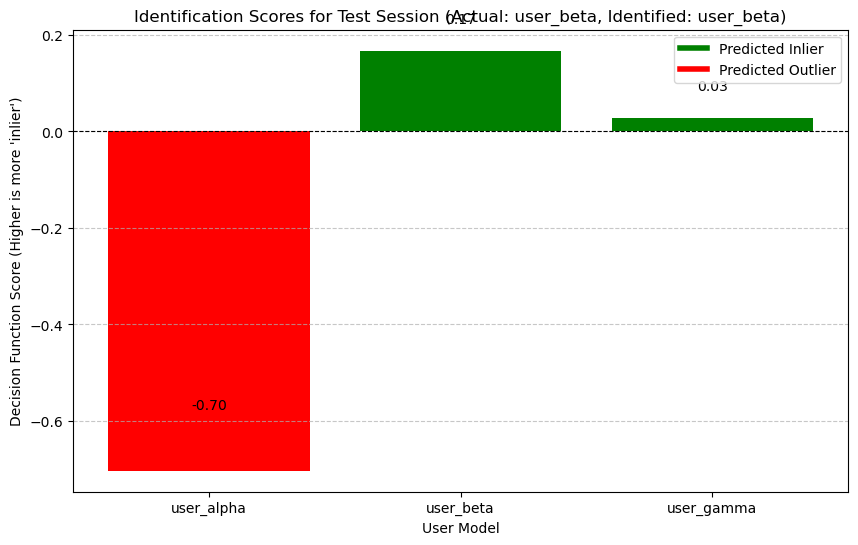

In [20]:
if 'scores' in locals() and scores: # Check if scores dictionary exists and is not empty
    user_names = list(scores.keys())
    score_values = list(scores.values())
    prediction_values = [predictions.get(usr, -1) for usr in user_names]

    colors = ['red' if pred == -1 else 'green' for pred in prediction_values]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(user_names, score_values, color=colors)
    plt.axhline(0, color='black', lw=0.8, linestyle='--') # Decision threshold for OneClassSVM

    plt.xlabel("User Model")
    plt.ylabel("Decision Function Score (Higher is more 'inlier')")
    plt.title(f"Identification Scores for Test Session (Actual: {test_user_origin}, Identified: {identified_user})")
    
    # Add text labels for scores
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + (0.05 if yval >=0 else -0.15) *np.sign(yval) , f"{yval:.2f}", ha='center', va='bottom' if yval >=0 else 'top')

    # Custom legend elements
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='green', lw=4, label='Predicted Inlier'),
                       Line2D([0], [0], color='red', lw=4, label='Predicted Outlier')]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("\nNo scores to visualize from the single test case, or test was not run.")